In [0]:
%pip install geopy

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import explode, col, lit, when
from pyspark.sql.types import StructType, StructField, StringType, LongType, DoubleType
from pyspark.sql.functions import monotonically_increasing_id
from geopy.geocoders import Nominatim
from pyspark.sql.functions import udf
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

In [0]:
base_s3_station_path = "s3://monthly-summary/raw/station.txt"
base_s3_ncdc_path = "s3://monthly-summary/raw/"

In [0]:
## 1. Data Handling

In [0]:
#### 1.1 Read Station Dataset 

In [0]:
station = spark.sparkContext.textFile(base_s3_station_path)

In [0]:

station_schema = StructType([
    StructField("station_id", StringType(), True),
    StructField("latitude", FloatType(), True),
    StructField("longitude", FloatType(), True),
    StructField("elevation", FloatType(), True),
    StructField("station_name", StringType(), True),
    StructField("GSN_flag", StringType(), True),
    StructField("HCN_CRN_flag", StringType(), True)
])


In [0]:
def parse_line(line):
    fields = line.split()
    station_id = fields[0]
    latitude = float(fields[1])
    longitude = float(fields[2])
    elevation = float(fields[3])

    # Initiate optional fields as None
    GSN_flag = None
    HCN_CRN_flag = None

    # Check the last field to see if it's a digit (HCN_CRN_flag)
    if fields[-1].isdigit():
        HCN_CRN_flag = fields.pop(-1)

    # Check the new last field to see if it's "GSN" (GSN_flag)
    if fields[-1] == 'GSN':
        GSN_flag = fields.pop(-1)

    # The remaining fields make up the station_name
    station_name = ' '.join(fields[4:])

    return (station_id, latitude, longitude, elevation, station_name, GSN_flag, HCN_CRN_flag)


In [0]:
df_station = spark.createDataFrame(station.map(parse_line), station_schema)

In [0]:
import random

# Set a seed for reproducibility
random.seed(42)

def generate_random_ranges(num_ranges, lower_bound, upper_bound, max_length):
    random_ranges = []
    for _ in range(num_ranges):
        start = random.randint(lower_bound, upper_bound - max_length)
        end = start + random.randint(1, max_length)
        if end > upper_bound:
            end = upper_bound
        random_ranges.append((start, end))
    return random_ranges

# Random Parameters
num_ranges = random.randint(5, 50)  # Random number of ranges between 5 and 50
lower_bound = random.randint(1, 500)  # Random lower bound between 1 and 500
upper_bound = random.randint(lower_bound+1, 121000)  # Random upper bound between lower_bound+1 and 121000
max_length = random.randint(5, 50)  # Random max length between 5 and 50

# Generate random ranges
random_ranges = generate_random_ranges(num_ranges, lower_bound, upper_bound, max_length)

print("Generated random ranges:", random_ranges)


Generated random ranges: [(1061, 1069), (629, 633), (2829, 2847), (414, 433), (1786, 1788), (180, 183), (953, 961), (2127, 2147), (166, 184), (872, 893), (2930, 2948), (1776, 1784), (1897, 1916), (1197, 1198), (3166, 3172), (2917, 2931), (1451, 1460), (694, 701), (3185, 3196), (476, 479), (1614, 1618), (1528, 1540), (2530, 2539), (235, 250), (2254, 2258), (1608, 1611), (2319, 2329), (2632, 2652), (1539, 1558), (845, 848), (245, 267), (991, 1001), (384, 392), (471, 484), (1196, 1211), (2661, 2673), (724, 736), (1513, 1520), (2803, 2812), (2932, 2954), (2712, 2715), (2553, 2574), (758, 776), (3044, 3052), (727, 742)]


In [0]:
ranges_to_extract = [(76579, 76584), (51065, 51067), (118788, 118799), (71990, 72011), (7014, 7028), (103608, 103620), (109198, 109199), (82627, 82642), (8559, 8567), (54851, 54859), (16663, 16688), (70099, 70104), (112875, 112883), (41699, 41706), (86602, 86626), (82372, 82380), (16901, 16914), (56659, 56686), (73009, 73030), (83371, 83393), (114401, 114418), (51951, 51972), (3286, 3289), (22476, 22498), (7512, 7533), (3310, 3327), (55663, 55686), (80549, 80576), (120917, 120929), (22618, 22645)]

In [0]:
station_ids = [row.station_id for row in df_station.select('station_id').collect()]
s3_file_paths = [f"s3://monthly-summary/raw/{station_id}.csv" for station_id in station_ids]

demo_paths = []
for start, end in ranges_to_extract:
    demo_paths.extend(s3_file_paths[start:end])

In [0]:
#### 1.2 Read Data Schema for Monthly Summary

In [0]:
weather_schema = StructType([
    # Core Columns
    StructField("STATION", StringType(), True),
    StructField("DATE", DateType(), True),
    StructField("LATITUDE", DoubleType(), True),
    StructField("LONGITUDE", DoubleType(), True),
    StructField("TAVG", DoubleType(), True),
    
    # Bonus: Climate Change Metric
    StructField("PRCP", DoubleType(), True)
])

In [0]:
##### Read Dta by chunck and stored in partitioned dataset

In [0]:
import boto3
from pyspark.sql import functions as F
s3 = boto3.client('s3')
chunk_size = 500

In [0]:
missing_files_1 = []
chunk_size = 100  #  adjust this value as needed
file_chunks_1 = [demo_paths[i:i + chunk_size] for i in range(0, len(demo_paths), chunk_size)]
final_df_1 = spark.createDataFrame([], schema=weather_schema)

# Define target columns and column aliases
# If i got more time to deeply consider the dataset, i will include TMAX and TIME to do data quality check of TAVG, instead of only choose TAVG. 

# The reason to keep latitude and longitude column (maybe redunant related to the station_id dataset which also contains lat & lont) here beacause i need to do avg temperature by coordinated locations, instead of run joinning query to match two large dataset

target_columns = ['STATION', 'DATE', 'LATITUDE', 'LONGITUDE','TAVG', 'PRCP']

for index, chunk in enumerate(file_chunks_1):
    print(f"Processing chunk {index+1} of {len(file_chunks_1)}")
    
    existing_files = []
    
    for file_path in chunk:
        bucket_name, key = file_path.replace("s3://", "").split("/", 1)
        try:
            s3.head_object(Bucket=bucket_name, Key=key)
            existing_files.append(file_path)
        except:
            print(f"File does not exist: {file_path}")
            missing_station_id = key.split('/')[-1].replace('.csv', '')
            missing_files_1.append(missing_station_id)
    
    if existing_files:
        # Read the CSV without specifying the schema
        temp_df = spark.read.option("header", "true").csv(existing_files)
        
        # Add missing columns and fill with null
        for col in target_columns:
            if col not in temp_df.columns:
                temp_df = temp_df.withColumn(col, F.lit(None).cast("string"))
        
        # Use select to specify the columns in the order you need
        temp_df = temp_df.select(*target_columns)
        
        # Union the temporary DataFrame with the final DataFrame
        final_df_1 = final_df_1.unionByName(temp_df)
        
        print(f"Appended chunk {index+1} to final DataFrame")

print(f"List of missing files: {missing_files_1}")




Processing chunk 1 of 5
Appended chunk 1 to final DataFrame
Processing chunk 2 of 5
File does not exist: s3://monthly-summary/raw/US1KSSG0127.csv
File does not exist: s3://monthly-summary/raw/US1SCLX0145.csv
Appended chunk 2 to final DataFrame
Processing chunk 3 of 5
File does not exist: s3://monthly-summary/raw/US1CAFR0009.csv
File does not exist: s3://monthly-summary/raw/US1CAFR0021.csv
File does not exist: s3://monthly-summary/raw/US1CAFR0022.csv
File does not exist: s3://monthly-summary/raw/US1CAFR0025.csv
File does not exist: s3://monthly-summary/raw/US1CAFR0027.csv
File does not exist: s3://monthly-summary/raw/US1CAFR0030.csv
File does not exist: s3://monthly-summary/raw/US1MIOW0047.csv
File does not exist: s3://monthly-summary/raw/US1OKCV0087.csv
File does not exist: s3://monthly-summary/raw/US1OKCV0111.csv
File does not exist: s3://monthly-summary/raw/SWE00140588.csv
Appended chunk 3 to final DataFrame
Processing chunk 4 of 5
File does not exist: s3://monthly-summary/raw/US1AZM

In [0]:
display(final_df_1)

STATION,DATE,LATITUDE,LONGITUDE,TAVG,PRCP
USC00502607,1901-11,64.7856,-141.2036,-18.71,6.3
USC00502607,1901-12,64.7856,-141.2036,-22.44,4.9
USC00502607,1902-02,64.7856,-141.2036,-14.77,0.0
USC00502607,1902-03,64.7856,-141.2036,-21.26,4.3
USC00502607,1902-04,64.7856,-141.2036,-2.97,21.4
USC00502607,1902-05,64.7856,-141.2036,7.30,16.2
USC00502607,1902-06,64.7856,-141.2036,13.38,29.3
USC00502607,1902-07,64.7856,-141.2036,16.40,64.9
USC00502607,1902-08,64.7856,-141.2036,12.51,32.7
USC00502607,1902-09,64.7856,-141.2036,5.48,16.6


In [0]:
final_df_1.write.mode('overwrite').parquet("s3://monthly-summary/final_df_demo.parquet")

In [0]:
##### Union dataframes if needed for large dataset

In [0]:
#assert list(final_df_1.columns) == list(final_df_2.columns), "DataFrames have different columns"
#combined_df = final_df_1.union(final_df_2)
combined_df = final_df_1

In [0]:
### 1.2 Data Transformation

In [0]:
#### Data Cleaning

In [0]:
# Data Cleaning
# Those are basic cleaning steps based on assessment goal, but more detailed steps can be adopted for any specific country 
def filter_missing_data(df: DataFrame) -> DataFrame:
    return df.filter(
        (F.col("TAVG").isNotNull())
    )

def filter_outliers(df: DataFrame) -> DataFrame:
    # Remove records where 'TAVG' exceeds 122 or is below -20
    return df.filter((F.col("TAVG") <= 122) & (F.col("TAVG") >= -20))

def convert_temperatures(df: DataFrame) -> DataFrame:
    # Convert temperatures based on the 'TAVG' column.
    # If 'TAVG' exceeds 50, assume it's in Fahrenheit and convert to Celsius.
    df = df.withColumn(
        "TAVG",
        F.when((F.col("TAVG") > 50), (F.col("TAVG") - 32) * 5 / 9)
        .otherwise(F.col("TAVG"))
    )
    return df


def add_time_and_season_columns(df: DataFrame) -> DataFrame:
    return df.withColumn("YEAR", F.substring("DATE", 1, 4)) \
            .withColumn("MONTH", F.substring("DATE", 6, 2)) \
            .withColumn("SEASON", 
                F.when((F.col("MONTH").between(3, 5)), "Spring")
                .when((F.col("MONTH").between(6, 8)), "Summer")
                .when((F.col("MONTH").between(9, 11)), "Autumn")
                .otherwise("Winter")
            )

def round_off_data(df: DataFrame) -> DataFrame:
    return df.withColumn("TAVG", F.round("TAVG", 2)) \
            .withColumn("PRCP", F.round("PRCP", 2)) 



In [0]:
# If i have TMAX and TMIN colum, i will also do:

def filter_temperature_data(df: DataFrame) -> DataFrame:
    return df.filter(
        (F.col("TMAX") >= F.col("TAVG")) &
        (F.col("TAVG") >= F.col("TMIN"))
    ).filter(
        (F.col("TMAX") > F.col("TAVG")) & (F.col("TAVG") > F.col("TMIN")) |
        (F.col("TMAX") == F.col("TAVG")) & (F.col("TAVG") == F.col("TMIN"))
    )

In [0]:
processed_df = filter_missing_data(combined_df)
processed_df = filter_outliers(processed_df)
processed_df = convert_temperatures(processed_df)
processed_df = add_time_and_season_columns(processed_df)
processed_df = round_off_data(processed_df)


In [0]:
processed_df = processed_df.withColumn("YEAR", F.substring("DATE", 1, 4))
processed_df = processed_df.withColumn("MONTH", F.substring("DATE", 6, 2))
processed_df = processed_df.withColumn("SEASON", 
                   F.when((F.col("MONTH").between(3, 5)), "Spring")
                   .when((F.col("MONTH").between(6, 8)), "Summer")
                   .when((F.col("MONTH").between(9, 11)), "Autumn")
                   .otherwise("Winter"))


In [0]:
processed_df.show(100)

+-----------+-------+--------+---------+------+----+----+-----+------+
|    STATION|   DATE|LATITUDE|LONGITUDE|  TAVG|PRCP|YEAR|MONTH|SEASON|
+-----------+-------+--------+---------+------+----+----+-----+------+
|USC00502607|1901-11| 64.7856|-141.2036|-18.71| 6.3|1901|   11|Autumn|
|USC00502607|1902-02| 64.7856|-141.2036|-14.77| 0.0|1902|   02|Winter|
|USC00502607|1902-04| 64.7856|-141.2036| -2.97|21.4|1902|   04|Spring|
|USC00502607|1902-05| 64.7856|-141.2036|   7.3|16.2|1902|   05|Spring|
|USC00502607|1902-06| 64.7856|-141.2036| 13.38|29.3|1902|   06|Summer|
|USC00502607|1902-07| 64.7856|-141.2036|  16.4|64.9|1902|   07|Summer|
|USC00502607|1902-08| 64.7856|-141.2036| 12.51|32.7|1902|   08|Summer|
|USC00502607|1902-09| 64.7856|-141.2036|  5.48|16.6|1902|   09|Autumn|
|USC00502607|1902-10| 64.7856|-141.2036| -0.08|19.6|1902|   10|Autumn|
|USC00502607|1902-11| 64.7856|-141.2036|-18.84|15.7|1902|   11|Autumn|
|USC00502607|1903-02| 64.7856|-141.2036|-15.28|20.6|1903|   02|Winter|
|USC00

In [0]:
print("Total rows in DataFrame:", processed_df.count())

Total rows in DataFrame: 12014


In [0]:
processed_df.write.mode('overwrite').parquet("s3://monthly-summary/Processed/Full_df_demo.parquet")

In [0]:
##### Q1: Average seasonal temperature for each season and year where data is available

In [0]:
seasonal_avg_df = (processed_df.groupBy("YEAR", "SEASON")
                     .agg(F.round(F.avg("TAVG"), 2).alias("AVG_SEASONAL_TEMP"))
                     .orderBy("YEAR", "SEASON"))


In [0]:
seasonal_avg_df.display()

YEAR,SEASON,AVG_SEASONAL_TEMP
1893,Autumn,3.98
1893,Winter,-0.73
1894,Autumn,10.97
1894,Spring,10.03
1894,Summer,21.49
1894,Winter,-1.32
1895,Autumn,10.73
1895,Spring,8.62
1895,Summer,21.36
1895,Winter,-3.52


In [0]:
seasonal_avg_df.write.mode('overwrite').parquet("s3://monthly-summary/Processed/seasonal_avg_demo.parquet")


In [0]:
##### Q2: List of weather stations and number of available datapoints

In [0]:
Ava_df = processed_df.groupBy("YEAR", "SEASON", "STATION").agg(
    round(F.avg("TAVG"),2).alias("average_temperature"),
    F.count("TAVG").alias("datapoints")
)

In [0]:
Ava_df.display()

YEAR,SEASON,STATION,average_temperature,datapoints
1993,Autumn,USC00502607,-3.38,3
1936,Summer,USC00502587,29.11,2
2007,Summer,USC00502587,29.5,3
2018,Summer,USC00502568,14.01,3
1924,Summer,USC00502607,13.04,3
1928,Summer,USC00502607,12.75,3
1948,Summer,USC00502607,12.98,3
2014,Autumn,USC00502607,-4.02,3
2017,Spring,USC00502607,-4.61,3
1933,Summer,USC00502587,21.94,3


In [0]:
Ava_df.write.mode('overwrite').parquet("s3://monthly-summary/Processed/Available_dtapoint_demo.parquet")

In [0]:
##### Q3: Accepts 2 sets of coordinates -prepare partition files

In [0]:
##### Bonus: 1. Identify Country of each station

In [0]:
geolocator = Nominatim(user_agent="geoapiExercises")
def get_country(latitude, longitude):
    from geopy.geocoders import Nominatim  # Import here
    geolocator = Nominatim(user_agent="kryhunnnn@gmail.com")
    location = geolocator.reverse((latitude, longitude), language='en')
    return location.raw['address']['country']

reverse = RateLimiter(geolocator.reverse, min_delay_seconds=5)
get_country_udf = udf(get_country)

In [0]:
# Add a new column for the country
df_with_country = df_station.withColumn("country", get_country_udf("latitude", "longitude"))
df_with_country.show()
# Due to the rate limit of public API, can't do filter

+-----------+--------+---------+---------+--------------------+--------+------------+--------------------+
| station_id|latitude|longitude|elevation|        station_name|GSN_flag|HCN_CRN_flag|             country|
+-----------+--------+---------+---------+--------------------+--------+------------+--------------------+
|ACW00011604| 17.1167| -61.7833|     10.1|ST JOHNS COOLIDGE...|    NULL|        NULL| Antigua and Barbuda|
|ACW00011647| 17.1333| -61.7833|     19.2|            ST JOHNS|    NULL|        NULL| Antigua and Barbuda|
|AE000041196|  25.333|   55.517|     34.0| SHARJAH INTER. AIRP|     GSN|       41196|United Arab Emirates|
|AEM00041194|  25.255|   55.364|     10.4|          DUBAI INTL|    NULL|       41194|United Arab Emirates|
|AEM00041217|  24.433|   54.651|     26.8|      ABU DHABI INTL|    NULL|       41217|United Arab Emirates|
|AEM00041218|  24.262|   55.609|    264.9|         AL AIN INTL|    NULL|       41218|United Arab Emirates|
|AF000040930|  35.317|   69.017|   33

In [0]:
# It has rate limit via public geopy api , if i got time i will try to use the other, but geopy can already satisfied bonu goal #1.
# df_filtered = df_with_country.filter(df_with_country.country != "Canada")
# df_filtered.show()

In [0]:
##### Bonus: 2. Change in global temperature/ precipitation

In [0]:
agg_df = processed_df.groupBy("STATION", "YEAR").agg(
    F.avg("TAVG").alias("avg_temp"),
    F.avg("PRCP").alias("avg_precip")
)

In [0]:
global_agg_df = agg_df.groupBy("YEAR").agg(
    round(F.avg("avg_temp")).alias("rounded_global_avg_temp"),
    F.avg("avg_precip").alias("global_avg_precip")
).orderBy("YEAR")
global_agg_pandas_df = global_agg_df.toPandas()


In [0]:
windowSpec = Window().partitionBy().orderBy("YEAR")
global_change_df = global_agg_df.withColumn("prev_rounded_global_avg_temp", F.lag("rounded_global_avg_temp").over(windowSpec))
global_change_df = global_change_df.withColumn("prev_global_avg_precip", F.lag("global_avg_precip").over(windowSpec))
global_change_df = global_change_df.withColumn("temp_change", (global_change_df["rounded_global_avg_temp"] - global_change_df["prev_rounded_global_avg_temp"]))
global_change_df = global_change_df.withColumn("precip_change", (global_change_df["global_avg_precip"] - global_change_df["prev_global_avg_precip"]))

In [0]:
global_change_pandas_df = global_change_df.toPandas()

/root/.ipykernel/3106/command-4394680920886817-2079993198:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(global_change_pandas_df.pivot("YEAR", "rounded_global_avg_temp", "temp_change"), annot=True, cmap="coolwarm", fmt=".1f")


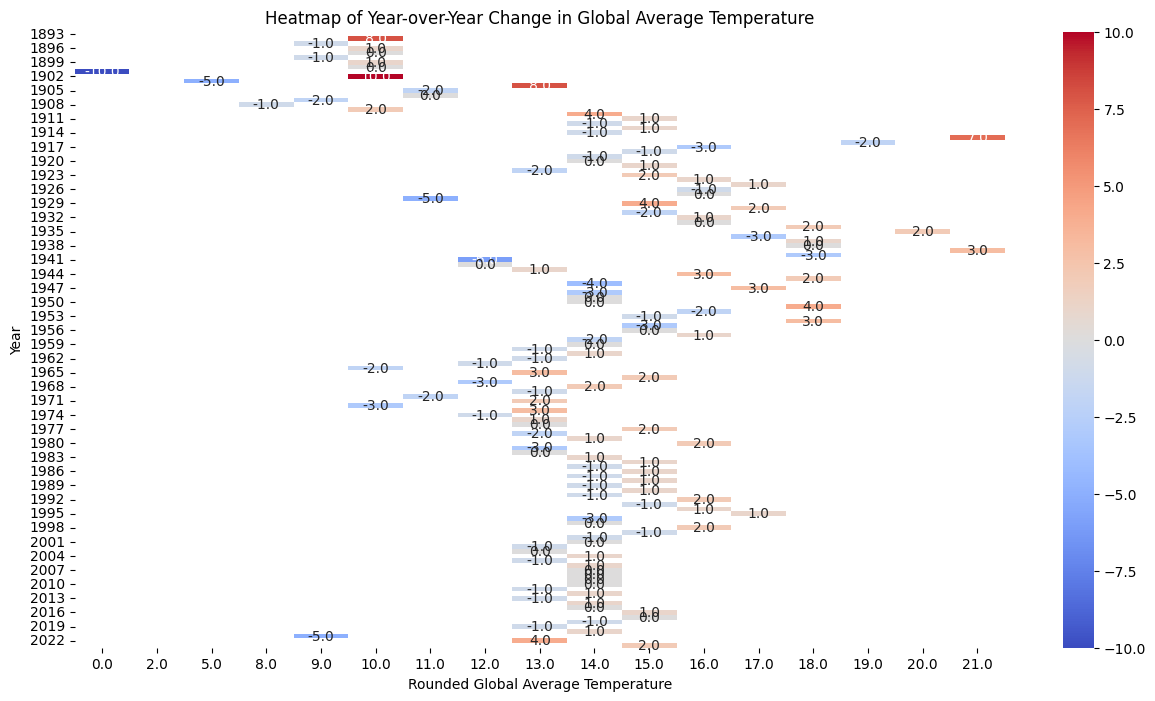

<Figure size 640x480 with 0 Axes>

In [0]:
# Create a heatmap for Year-over-Year Temperature Change
plt.figure(figsize=(15, 8))
sns.heatmap(global_change_pandas_df.pivot("YEAR", "rounded_global_avg_temp", "temp_change"), annot=True, cmap="coolwarm", fmt=".1f")
plt.title('Heatmap of Year-over-Year Change in Global Average Temperature')
plt.xlabel('Rounded Global Average Temperature')
plt.ylabel('Year')
plt.show()
plt.savefig("heatmap_temp_change.png")

/root/.ipykernel/1771/command-4394680920886818-382939303:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(global_change_pandas_df.pivot("YEAR", "rounded_global_avg_temp", "precip_change"), annot=True, cmap="coolwarm", fmt=".1f")


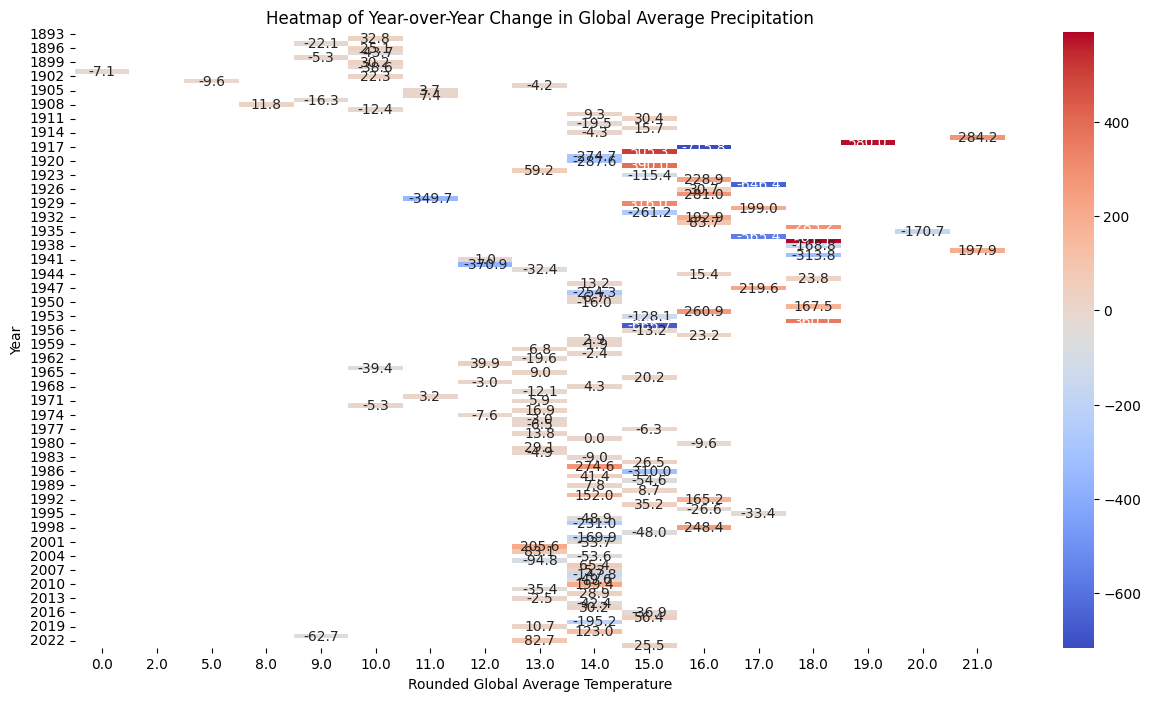

<Figure size 640x480 with 0 Axes>

In [0]:
# Create a heatmap for Year-over-Year Precipitation Change
plt.figure(figsize=(15, 8))
sns.heatmap(global_change_pandas_df.pivot("YEAR", "rounded_global_avg_temp", "precip_change"), annot=True, cmap="coolwarm", fmt=".1f")
plt.title('Heatmap of Year-over-Year Change in Global Average Precipitation')
plt.xlabel('Rounded Global Average Temperature')
plt.ylabel('Year')
plt.show()
plt.savefig("heatmap_precip_change.png")

In [0]:
files = ["heatmap_temp_change.png", "heatmap_precip_change.png"]
for file in files:
    s3.upload_file(file, 'monthly-summary', file)


In [0]:
##### Q3: Identify Outliers

In [0]:
##### I already try to deal with abnormal values, trade-offs between data integrity & data accuracy

In [0]:
def filter_outliers(df: DataFrame) -> DataFrame:
    # Remove records where 'TAVG' exceeds 122 or is below -20
    return df.filter((F.col("TAVG") <= 122) & (F.col("TAVG") >= -20))

def convert_temperatures(df: DataFrame) -> DataFrame:
    # Convert temperatures based on the 'TAVG' column.
    # If 'TAVG' exceeds 50, assume it's in Fahrenheit and convert to Celsius.
    df = df.withColumn(
        "TAVG",
        F.when((F.col("TAVG") > 50), (F.col("TAVG") - 32) * 5 / 9)
        .otherwise(F.col("TAVG"))
    )
    return df

In [0]:
# Also, if i can have more time to figure out the geopy api problem,i would definitely do the analysis via continents, which are more suitable to do a weather analysis than using a global data.